In [2]:
import numpy as np
import pandas as pd

fps = ['./SW_OPER_MAGB_HR_1B_1349_20140219T020540_20140219T034014.pkl',
       './aux_SW_OPER_MAGB_HR_1B_1349_20140219T020540_20140219T034014.pkl',
       './IGRF_SW_OPER_MAGB_HR_1B_1349_20140219T020540_20140219T034014.pkl',
       './SW_EXPT_EFIB_TCT16_1349_20140219T020540_20140219T034014.pkl']
df_b = pd.read_pickle(fps[0])
df_b_aux = pd.read_pickle(fps[1])
df_b_IGRF = pd.read_pickle(fps[2])
df_e = pd.read_pickle(fps[3])

st = '20140219T023100'
et = '20140219T024100'
df_b_clip = df_b[['B_NEC', 'Longitude', 'Latitude', 'Radius']]
df_b_clip = df_b_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_b_aux_clip = df_b_aux[['QDLat', 'QDLon', 'MLT']]
df_b_aux_clip = df_b_aux_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]

In [10]:
df_b_IGRF_clip = df_b_IGRF[['B_NEC_IGRF']]
df_b_IGRF_clip = df_b_IGRF_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]
df_e_clip = df_e[['Longitude', 'Latitude', 'Radius', 'VsatE', 'VsatN', 'Ehy', 'Ehx']]
df_e_clip = df_e_clip.loc[pd.Timestamp(st):pd.Timestamp(et)]

from pyaw import utils

ehx, ehy = df_e_clip['Ehx'].values, df_e_clip['Ehy'].values
ehx, ehy = utils.set_outliers_nan_std(ehx), utils.set_outliers_nan_std(ehy)
ehx, ehy = utils.get_array_interpolated(df_e_clip.index.values, ehx), utils.get_array_interpolated(
    df_e_clip.index.values, ehy)

rotation_matrix_2d_nec2sc, rotation_matrix_2d_sc2nec = utils.get_rotmat_nec2sc_sc2nec(df_e_clip['VsatN'].values,
                                                                                      df_e_clip['VsatE'].values)
ehn, ehe = utils.do_rotation(-ehx, -ehy, rotation_matrix_2d_sc2nec)

1340
[ 31.04151   31.12732   30.72822  ... -16.934528 -17.28755  -17.26635 ]
1884
[-68.04985  -67.73227  -67.709724 ... -68.94558  -67.77986  -68.15865 ]


In [11]:
import numpy as np

np.all(np.equal(df_b_clip.index.values,df_b_IGRF_clip.index.values))

True

In [12]:
_, be, _ = utils.get_3arrs(df_b_clip['B_NEC'].values)
_,be_igrf,_ = utils.get_3arrs(df_b_IGRF_clip['B_NEC_IGRF'].values)
be1 = be - be_igrf

In [13]:
datetimes_e = df_e_clip.index.values
datetimes_b = df_b_clip.index.values

be1 = utils.align_high2low(be1, datetimes_b, datetimes_e)

In [14]:

from scipy.signal import stft

fs = 16
window = 'hann'
stft_window_seconds = 4  # second
nperseg = int(stft_window_seconds * fs)  # 每个窗的采样点数
noverlap = nperseg // 2  # 50%重叠

# get stft
freqs, ts, Zxx_e = stft(ehn, fs, window=window, nperseg=nperseg, noverlap=noverlap,
                        scaling='psd')
_, _, Zxx_b = stft(be1, fs, window=window, nperseg=nperseg, noverlap=noverlap,
                   scaling='psd')

ts_dt64 = datetimes_e[0] + [np.timedelta64(int(_), 's') for _ in ts]

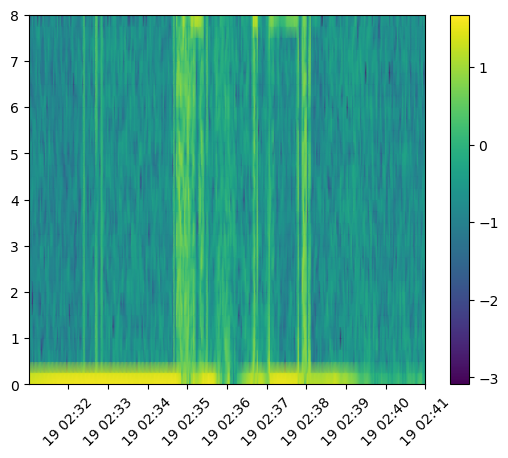

In [15]:

import matplotlib.pyplot as plt

Zxx_e_m = np.abs(Zxx_e)
plt.pcolormesh(ts_dt64, freqs, np.log10(Zxx_e_m), shading='gouraud')  # 可以用初始值也可以用log10
plt.colorbar()
plt.xticks(rotation=45)
plt.show()

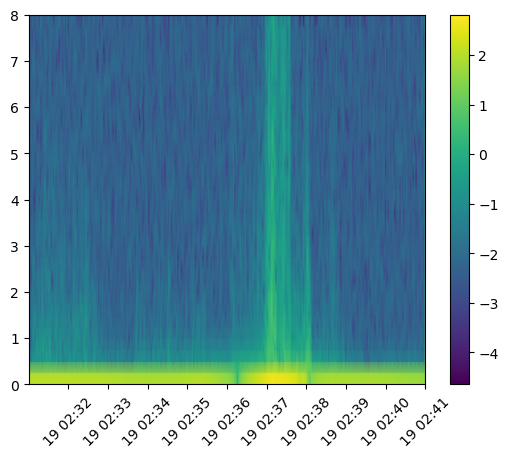

In [16]:

Zxx_b_m = np.abs(Zxx_b)
plt.pcolormesh(ts_dt64, freqs, np.log10(Zxx_b_m), shading='gouraud')
plt.colorbar()
plt.ylim([0, 8])
plt.xticks(rotation=45)
plt.show()

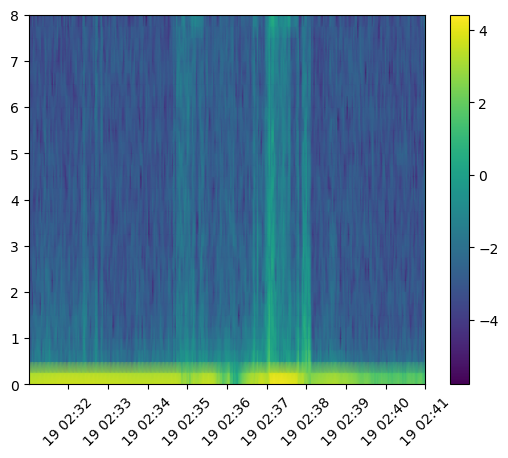

In [17]:

cross_e_b_spectral_density = Zxx_e * np.conj(Zxx_b)

cross_e_b_spectral_density_module = np.abs(cross_e_b_spectral_density)
plt.pcolormesh(ts_dt64, freqs, np.log10(cross_e_b_spectral_density_module), shading='gouraud')
plt.xticks(rotation=45)
plt.colorbar()
plt.show()

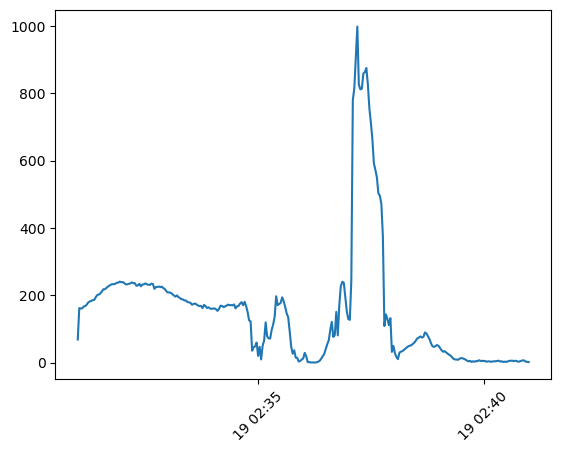

In [18]:

plt.figure()
plt.plot(ts_dt64, cross_e_b_spectral_density_module.mean(axis=0))
plt.xticks(rotation=45)
plt.show()


In [19]:

def split_array(data, step=11):
    # Split the array
    result = [data[:, i:i + step] for i in range(0, data.shape[1] - step, step)]
    # Add the remaining columns to the last segment
    remainder = data[:, step * len(result):]
    if remainder.size > 0:
        if len(result) > 0:
            # Append remaining columns to the last split
            result[-1] = np.hstack((result[-1], remainder))
        else:
            # If there's no initial split, the remainder is the only result
            result.append(remainder)
    # # Convert result to a NumPy array (optional)
    # print(f"Number of resulting arrays: {len(result)}")
    # for idx, arr in enumerate(result):
    #     print(f"Shape of array {idx}: {arr.shape}")
    return result


In [20]:

cross_e_b_spectral_density_split = split_array(cross_e_b_spectral_density)  # ls
denominator1ls = split_array(np.abs(Zxx_e ** 2))
denominator2ls = split_array(np.abs(Zxx_b ** 2))

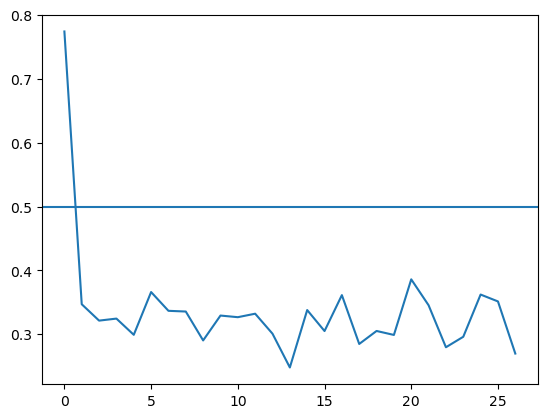

In [21]:

coherences_f = []
for i in range(len(cross_e_b_spectral_density_split)):
    nominator = cross_e_b_spectral_density_split[i].mean(axis=1)
    denominator = np.sqrt(denominator1ls[i].mean(axis=1)) * np.sqrt(denominator2ls[i].mean(axis=1))
    coherences_f.append(nominator / denominator)
    # denominator = sum(cross_e_b_spectral_density_module_split[i]) / len(cross_e_b_spectral_density_module_split[i])
    # nominator = np.sqrt(sum(nominator1ls[i]) / len(nominator1ls[i])) * np.sqrt(sum(nominator2ls[i]) / len(nominator2ls[i]))
    # coherences_spec.append(sum(np.abs(denominator / nominator)) / len(np.abs(denominator / nominator)))

coherences = []
for c_f in coherences_f:
    coherences.append(np.abs(c_f).mean())

plt.figure()
plt.plot(coherences)
plt.axhline(0.5)
plt.show()

denominator: [ 68.60417565-0.10776346j 162.15939375+0.32300998j
 160.76328861-0.26918497j 161.51154908-0.11762517j
 166.81434832+0.13582104j 168.20179032-0.5292465j
 172.50531012+0.26837566j 178.99118961-0.66088804j
 181.72740788-0.55780174j 183.69241818+0.13538909j
 185.52805638-0.51850047j]
nominator: [ 68.63752615 162.25347938 160.82958476 161.57922779 166.86402644
 168.28362087 172.57889536 179.0570386  181.83595708 183.76749724
 185.58474218]
denominator/nominator [0.99951411-0.00157004j 0.99942013+0.00199077j 0.99958779-0.00167373j
 0.99958114-0.00072797j 0.99970228+0.00081396j 0.99951373-0.00314497j
 0.99957361+0.00155509j 0.99963225-0.00369094j 0.99940304-0.00306761j
 0.99959145+0.00073674j 0.99969456-0.00279387j]
coherency: 0.9995673774977163
----------------------------------------
denominator: [186.46259477-6.42066419e-01j 194.62525021-6.18007164e-01j
 201.02471331-4.32890368e-01j 202.27306832-2.46830551e-04j
 205.72514285-5.61155275e-01j 211.29497056-2.92206473e-01j
 217.90

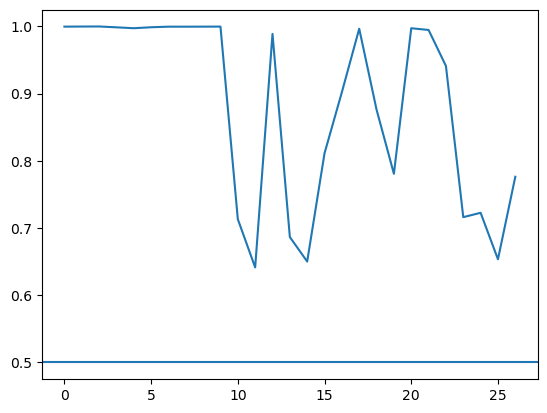

In [22]:

S_By_Ex_split_spec = split_array(cross_e_b_spectral_density)
nominator1ls = split_array(np.abs(Zxx_e ** 2))
nominator2ls = split_array(np.abs(Zxx_b ** 2))
coherences_spec = []
for i in range(len(S_By_Ex_split_spec)):
    denominator = sum(S_By_Ex_split_spec[i]) / len(S_By_Ex_split_spec[i])
    nominator = np.sqrt(sum(nominator1ls[i]) / len(nominator1ls[i])) * np.sqrt(
        sum(nominator2ls[i]) / len(nominator2ls[i]))
    print("denominator:", denominator)
    print("nominator:", nominator)
    print("denominator/nominator", denominator / nominator)
    print("coherency:", sum(np.abs(denominator / nominator)) / len(np.abs(denominator / nominator)))
    print("----------------------------------------")
    coherences_spec.append(sum(np.abs(denominator / nominator)) / len(np.abs(denominator / nominator)))

plt.figure()
plt.plot(coherences_spec)
plt.axhline(0.5)
plt.show()


